In [1]:
import shutil

shutil.rmtree('kt_tuner_dir', ignore_errors=True)

GITHUB REPO: https://github.com/kamilakuss/disaster_tweets

# Natural Language Processing with Disaster Tweets

## Introduction

In recent years, Twitter has emerged as a prominent platform for real-time communication, particularly during emergencies and natural disasters. Individuals often use the platform to report incidents as they unfold, offering valuable situational awareness for disaster response organizations, news agencies, and public safety authorities. However, not all tweets containing alarming language refer to actual emergencies—some use figurative or metaphorical expressions that can be misinterpreted by automated systems.

This project explores a text classification task that seeks to address this challenge: distinguishing between tweets that describe real disasters and those that do not. The dataset and problem are derived from a Kaggle competition designed to introduce participants to natural language processing (NLP) in a practical and accessible manner. Participants are tasked with developing a machine learning model capable of accurately classifying tweets based on their content, using a labeled dataset of 7,613 examples.

By applying fundamental NLP techniques and machine learning algorithms, this project aims to build a robust classification system that can support real-world disaster monitoring efforts by enhancing the ability to automatically filter relevant information from social media.

## Problem Description

The objective of this project is to construct a supervised binary classification model to predict whether a given tweet refers to a real disaster. The task falls under the domain of Natural Language Processing (NLP), with a primary focus on text preprocessing, feature extraction, and model development for short, informal text data.


In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

import keras_tuner as kt

In [3]:
#import data
train_path = "./input/train.csv"
test_path = "./input/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### Dataset Overview

The dataset consists of two primary components: a training set and a test set.

- **Training Set (`train.csv`)**
  - 7,613 rows and 5 columns:
    - `id`: Unique identifier for each tweet
    - `keyword`: A relevant disaster-related keyword (optional feature; missing in some entries)
    - `location`: Geographical location from where the tweet was sent (highly sparse)
    - `text`: The tweet content (primary input for classification)
    - `target`: Binary label indicating if the tweet refers to a real disaster (`1`) or not (`0`)

- **Test Set (`test.csv`)**
  - 3,263 rows and 4 columns (same as training data, excluding the `target` column)

The tweet texts in this dataset are informal, often contain slang, abbreviations, and inconsistent grammar or punctuation. Additionally, the optional features (`keyword` and `location`) contain a substantial number of missing values, requiring careful preprocessing.

This project involves:
- Exploratory data analysis (EDA) to understand the distribution and quality of the data.
- Text preprocessing techniques such as tokenization, stopword removal, and lemmatization.
- Feature extraction using methods like TF-IDF or word embeddings.
- Model training and evaluation using algorithms including logistic regression, Naive Bayes, and transformer-based models.

The end goal is to achieve a high-performing classifier that generalizes well to unseen tweet data in the test set.

In [8]:
# Check if balanced
print(train_df['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


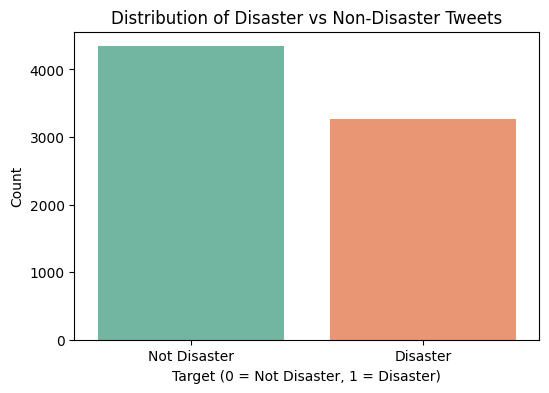

In [9]:
# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df, hue='target', palette='Set2', legend=False)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()


In [10]:
# Check missing data
missing_values = train_df.isnull().sum()
print("Missing values:\n", missing_values)


Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


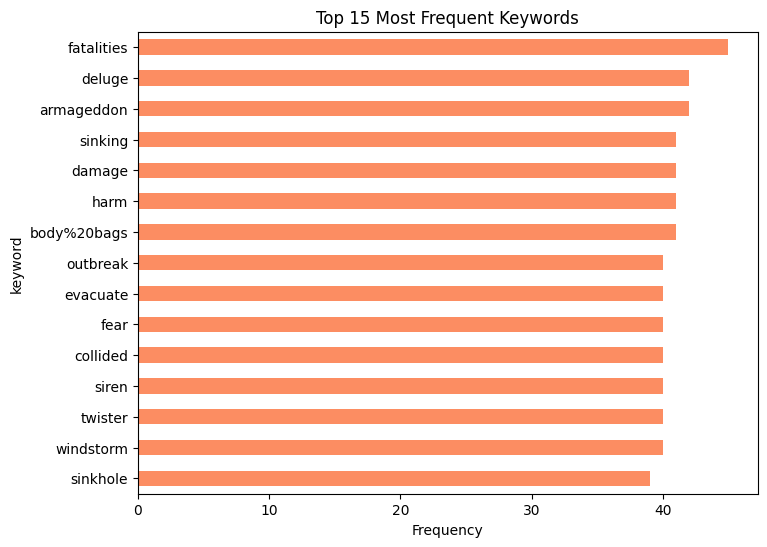

In [11]:
# Keyword frequency (top 15)
plt.figure(figsize=(8, 6))
train_df['keyword'].value_counts().head(15).plot(kind='barh', color='#fc8d62')
plt.title('Top 15 Most Frequent Keywords')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.show()

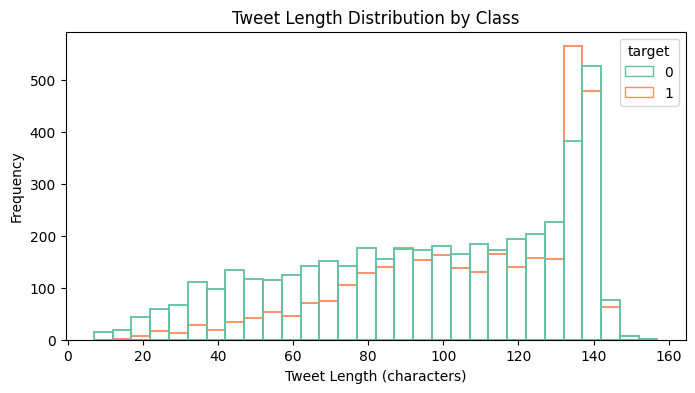

In [12]:
# Tweet length distribution

train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(
    data=train_df,
    x='text_length',
    bins=30,
    hue='target',
    palette='Set2',
    stat='count',
    common_norm=False, 
    fill = False
)
plt.title('Tweet Length Distribution by Class')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Fill missing keywords with "none"
train_df['keyword'] = train_df['keyword'].fillna("none")
test_df['keyword'] = test_df['keyword'].fillna("none")

# Drop location — too sparse
train_df.drop(columns=['location'], inplace=True)
test_df.drop(columns=['location'], inplace=True)


### Model Architecture and Text Embedding Strategy

For this project, I built a sequential neural network using a Long Short-Term Memory (LSTM) architecture to classify tweets as either disaster-related or not. Since tweets are short texts with temporal word dependencies, LSTM networks are well-suited for this task due to their ability to retain context over sequences of words and mitigate the vanishing gradient problem seen in traditional RNNs.

#### Word Embedding Strategy

To convert raw text into a numerical format suitable for input into a neural network, I used the Keras `Tokenizer` to tokenize the tweets and represent them using learned word embeddings via the `Embedding` layer. This method differs from traditional approaches like TF-IDF, which generates sparse and high-dimensional vectors without capturing word semantics. Instead, the `Embedding` layer maps words into dense vectors where semantically similar words are placed closer in the vector space.

Although methods like GloVe and Word2Vec offer pre-trained word embeddings based on large corpora, I opted to learn embeddings during training. This allows the model to capture context-specific relationships unique to the disaster tweet dataset, which may differ from general corpora.

#### Model Architecture

The model architecture is as follows:

- **Embedding Layer**: Transforms each word into a 64-dimensional dense vector. The vocabulary size is limited to 10,000 most frequent words, and the maximum sequence length is set to 50 tokens.
- **LSTM Layer**: Contains 64 units and includes dropout and recurrent dropout of 0.2 to reduce overfitting. The LSTM captures sequential patterns and dependencies in the text.
- **Dense Layer**: A fully connected layer with 32 units and ReLU activation introduces non-linearity.
- **Dropout Layer**: Applied to reduce overfitting by randomly deactivating neurons during training.
- **Output Layer**: A single neuron with sigmoid activation outputs a probability indicating whether a tweet is disaster-related.

The model is trained using the binary cross-entropy loss function and the Adam optimizer for efficient gradient descent. A validation split is used to monitor model performance during training.

This architecture balances performance with interpretability and is particularly suitable for short-text classification tasks such as tweet classification.

---

### References

1. Chollet, F. (2017). *Deep Learning with Python*. Manning Publications.
2. Kaggle. (2020). [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)
3. Goldberg, Y. (2016). *A Primer on Neural Network Models for Natural Language Processing*. Journal of Artificial Intelligence Research, 57, 345–420.

In [14]:
# Features and labels
X = train_df['text']
y = train_df['target']

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # remove mentions/hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special characters
    return text

X = X.astype(str).apply(clean_text)
X = X.apply(clean_text)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Tokenize and pad
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

# Build model
model = Sequential([
    Embedding(input_dim=15000, output_dim=64, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile and train
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5705 - loss: 0.6876 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5786 - loss: 0.6821 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5742 - loss: 0.6831 - val_accuracy: 0.5739 - val_loss: 0.6839
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5728 - loss: 0.6831 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5707 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6822


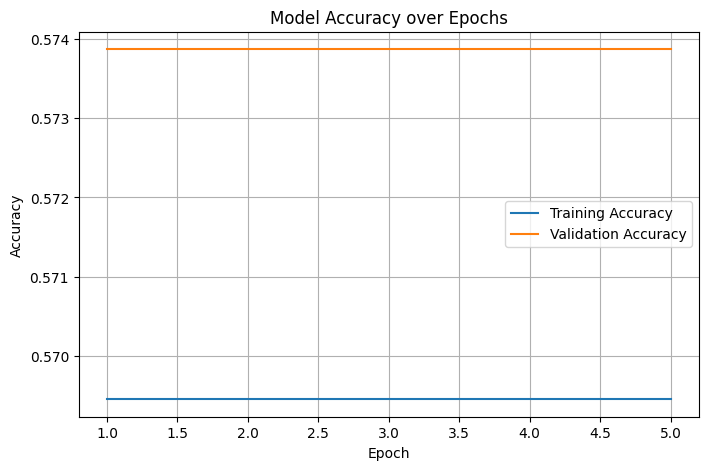

In [16]:
# Convert history to DataFrame
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index + 1  # add epoch numbers

# Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_df['epoch'], history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['epoch'], history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from sklearn.utils import class_weight
import numpy as np

# Update max_len if needed (context matters in NLP)
max_len = 150

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [ ]:
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(input_dim=10000,
                        output_dim=hp.Choice('embedding_dim', [32, 64, 128]),
                        input_length=max_len))
    model.add(Bidirectional(LSTM(units=hp.Choice('lstm_units', [32, 64, 128]),
                                 dropout=hp.Float('dropout', 0.1, 0.5, step=0.1),
                                 recurrent_dropout=hp.Float('recurrent_dropout', 0.1, 0.5, step=0.1))))
    model.add(Dense(units=hp.Choice('dense_units', [16, 32, 64]), activation='relu'))
    model.add(Dropout(hp.Float('dense_dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam'])
    optimizer = tf.keras.optimizers.get(optimizer_name)
    optimizer.learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='kt_tuner_dir',
    project_name='disaster_tweet_rnn_tuning_v2'
)

tuner.search(
    X_train_pad, y_train,
    epochs=10,
    validation_data=(X_val_pad, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')],
    class_weight=class_weights
)

Trial 5 Complete [01h 11m 01s]
val_accuracy: 0.7856205105781555

Best val_accuracy So Far: 0.8040052652359009
Total elapsed time: 01h 35m 52s


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=5)
all_histories = []

for i, hp in enumerate(best_hps):
    print(f"\nRetraining best model #{i+1} with hyperparameters:")
    print(hp.values)

    model = tuner.hypermodel.build(hp)
    history = model.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=hp.values.get('batch_size', 64),  # defaults if not tuned
        validation_data=(X_val_pad, y_val),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')],
        class_weight=class_weights
    )
    all_histories.append({
        'trial_id': i,
        'params': hp.values,
        'history': history.history
    })


Retraining best model #1 with hyperparameters:
{'embedding_dim': 32, 'lstm_units': 32, 'dropout': 0.1, 'recurrent_dropout': 0.30000000000000004, 'dense_units': 64, 'dense_dropout': 0.4, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5019 - loss: 0.6921 - val_accuracy: 0.7091 - val_loss: 0.6209
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7130 - loss: 0.5844 - val_accuracy: 0.7663 - val_loss: 0.4963
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8074 - loss: 0.4396 - val_accuracy: 0.7951 - val_loss: 0.4578
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8578 - loss: 0.3595 - val_accuracy: 0.8024 - val_loss: 0.4500
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8776 - loss: 0.3234 - val_accuracy: 0.7663 - val_loss: 0.5289
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8959 - loss: 0.2844 - val_accuracy: 0.7892 - val_loss: 0.4690

Retraining best model #2 with hyperparameters:
{'embedding_dim': 64, 'lstm_units': 64, 'dropout': 0.1, 'recurrent_dropout': 0.2, 'dense_units': 16, 'dense_dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0001}
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━


=== Top Model Trials ===
   Trial  Embedding Dim  LSTM Units  Dropout  Recurrent Dropout  Dense Units  \
0      0             32          32      0.1                0.3           64   
1      1             64          64      0.1                0.2           16   
4      4             32          32      0.5                0.5           64   
3      3            128          32      0.1                0.4           64   
2      2             32         128      0.4                0.1           16   

   Dense Dropout Optimizer  Learning Rate  Val Accuracy  Final Val Loss  
0            0.4   rmsprop         0.0010        0.8024          0.4690  
1            0.1      adam         0.0001        0.7938          0.4694  
4            0.4     nadam         0.0100        0.7932          0.5720  
3            0.3      adam         0.0010        0.7905          0.5759  
2            0.2     nadam         0.0001        0.7886          0.4824  


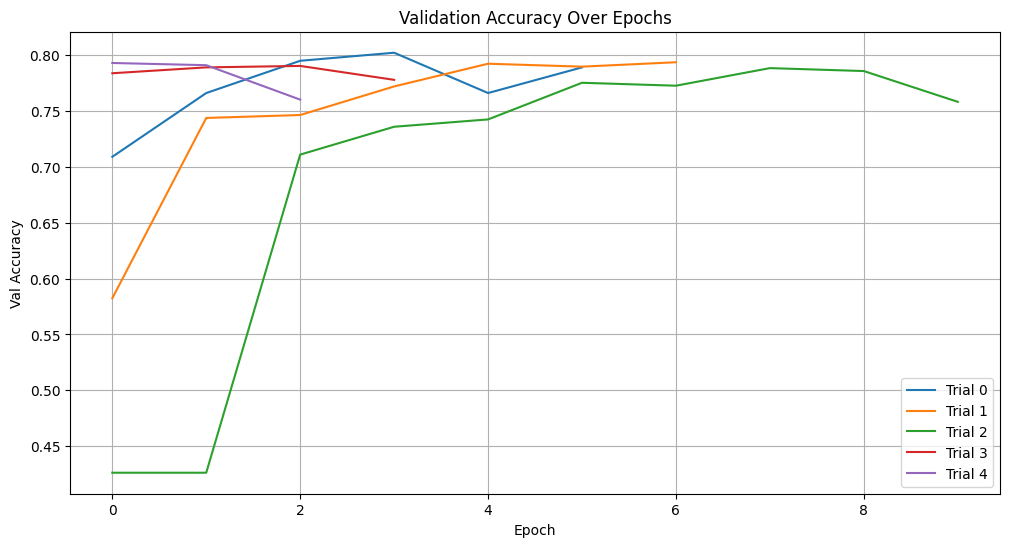

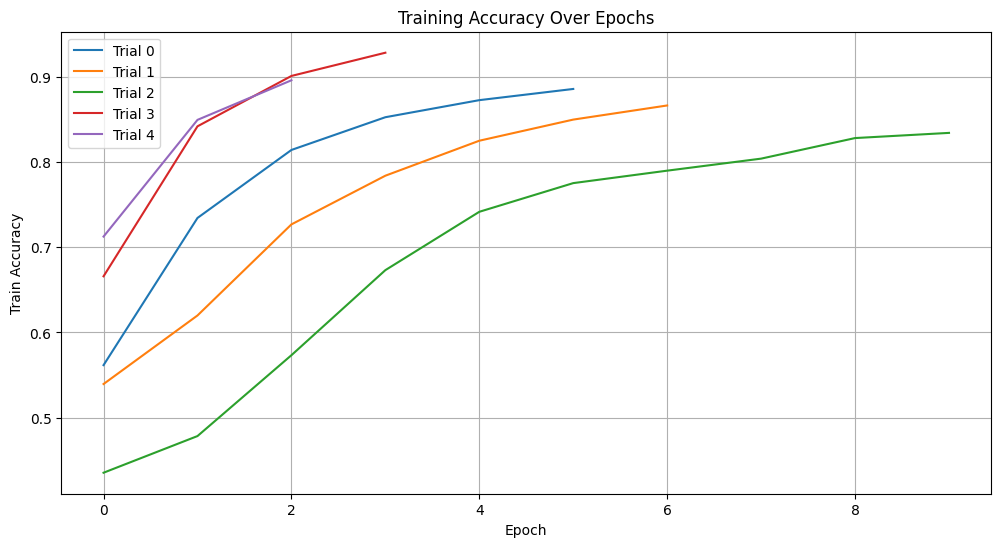

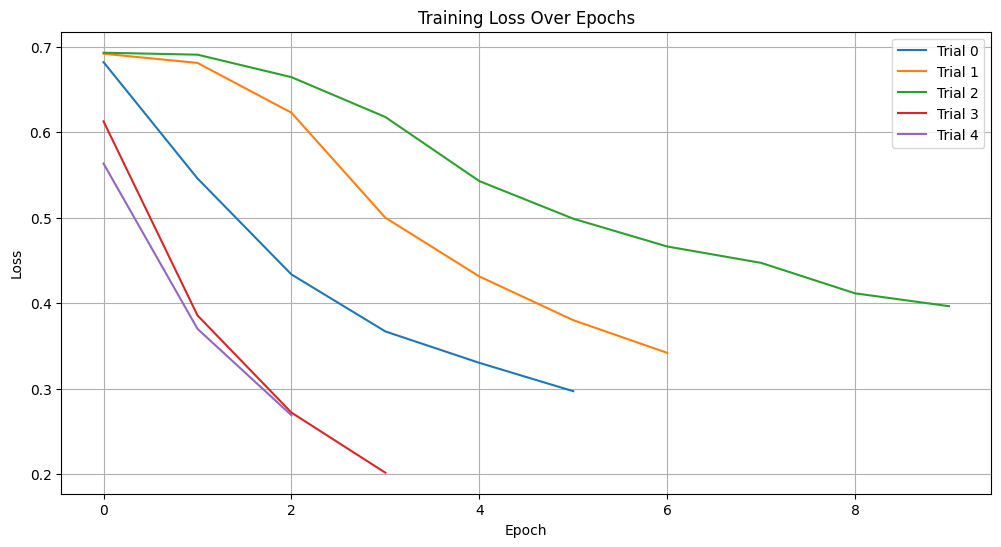

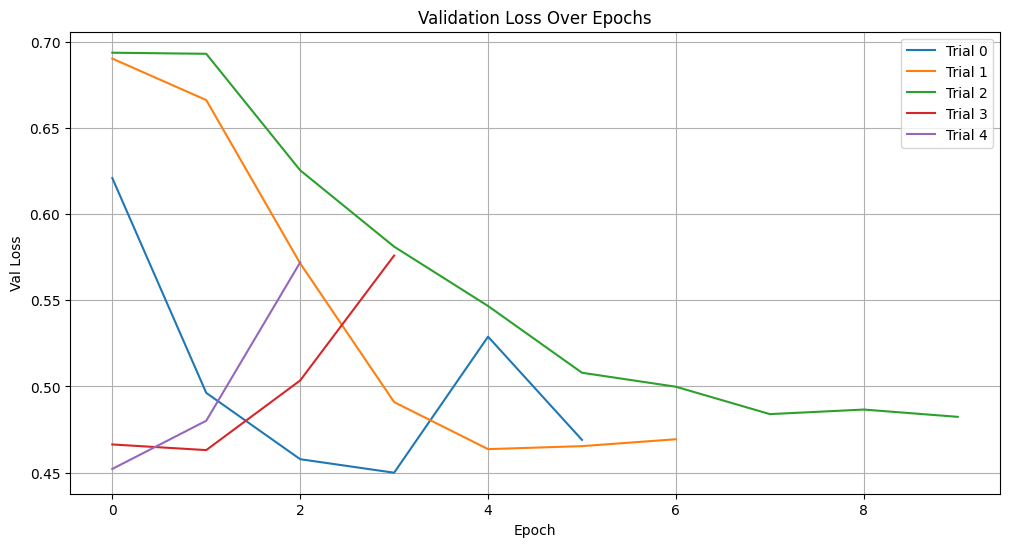


Best trial: #0
   Trial  Embedding Dim  LSTM Units  Dropout  Recurrent Dropout  Dense Units  \
0      0             32          32      0.1                0.3           64   

   Dense Dropout Optimizer  Learning Rate  Val Accuracy  Final Val Loss  
0            0.4   rmsprop          0.001        0.8024           0.469  


In [ ]:
# Create output directory
os.makedirs("figures", exist_ok=True)

#  Prepare results DataFrame 
results = []
for trial in all_histories:
    params = trial['params']
    best_val_acc = max(trial['history']['val_accuracy'])
    final_val_loss = trial['history']['val_loss'][-1]
    results.append({
        'Trial': trial['trial_id'],
        'Embedding Dim': params['embedding_dim'],
        'LSTM Units': params['lstm_units'],
        'Dropout': round(params['dropout'], 2),
        'Recurrent Dropout': round(params['recurrent_dropout'], 2),
        'Dense Units': params['dense_units'],
        'Dense Dropout': round(params['dense_dropout'], 2),
        'Optimizer': params['optimizer'],
        'Learning Rate': params['learning_rate'],
        'Val Accuracy': round(best_val_acc, 4),
        'Final Val Loss': round(final_val_loss, 4)
    })

results_df = pd.DataFrame(results)
results_df.to_csv("figures/tuning_results.csv", index=False)

#print("\n Top Model Trials ") --moved to markdown
#print(results_df.sort_values('Val Accuracy', ascending=False).head())


#  Plot validation accuracy over epochs 
plt.figure(figsize=(12, 6))
for trial in all_histories:
    plt.plot(trial['history']['val_accuracy'], label=f"Trial {trial['trial_id']}")
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("figures/val_accuracy_epochs.png")
plt.show()

#  Plot training accuracy over epochs 
plt.figure(figsize=(12, 6))
for trial in all_histories:
    plt.plot(trial['history']['accuracy'], label=f"Trial {trial['trial_id']}")
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("figures/train_accuracy_epochs.png")
plt.show()

#  Plot training loss 
plt.figure(figsize=(12, 6))
for trial in all_histories:
    plt.plot(trial['history']['loss'], label=f"Trial {trial['trial_id']}")
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("figures/train_loss_epochs.png")
plt.show()

#  Plot validation loss 
plt.figure(figsize=(12, 6))
for trial in all_histories:
    plt.plot(trial['history']['val_loss'], label=f"Trial {trial['trial_id']}")
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend()
plt.grid(True)
plt.savefig("figures/val_loss_epochs.png")
plt.show()

#  Best Model Summary 
best_model_idx = results_df.sort_values('Val Accuracy', ascending=False).iloc[0]['Trial']
print(f"\nBest trial: #{int(best_model_idx)}")
print(results_df.loc[results_df['Trial'] == best_model_idx])

## Hyperparameter Optimization Summary and Analysis

### Objective

The objective was to enhance the performance of an LSTM-based text classification model for disaster tweet detection by applying hyperparameter optimization using Keras Tuner's RandomSearch strategy.

### Hyperparameter Optimization Procedure

- **Tuner:** `kt.RandomSearch`
- **Trials:** 5
- **Executions per Trial:** 2
- **Search Space:**
  - `embedding_dim`: [32, 64, 128]
  - `lstm_units`: [32, 64, 128]
  - `dropout` and `recurrent_dropout`: [0.1 to 0.5]
  - `dense_units`: [16, 32, 64]
  - `dense_dropout`: [0.1 to 0.5]
  - `optimizer`: ['adam', 'rmsprop', 'nadam']
  - `learning_rate`: [1e-2, 1e-3, 1e-4]

An early stopping callback was applied with a patience of 2 to prevent overfitting and reduce unnecessary computation.

### Top Trials and Performance

| Trial | Embedding Dim | LSTM Units | Dropout | Recurrent Dropout | Dense Units | Dense Dropout | Optimizer | Learning Rate | Val Accuracy | Final Val Loss |
|-------|----------------|-------------|---------|--------------------|--------------|----------------|-----------|----------------|---------------|-----------------|
| 0     | 32             | 32          | 0.1     | 0.3                | 64           | 0.4            | rmsprop   | 0.0010         | 0.8024        | 0.4690          |
| 1     | 64             | 64          | 0.1     | 0.2                | 16           | 0.1            | adam      | 0.0001         | 0.7938        | 0.4694          |
| 4     | 32             | 32          | 0.5     | 0.5                | 64           | 0.4            | nadam     | 0.0100         | 0.7932        | 0.5720          |
| 3     | 128            | 32          | 0.1     | 0.4                | 64           | 0.3            | adam      | 0.0010         | 0.7905        | 0.5759          |
| 2     | 32             | 128         | 0.4     | 0.1                | 16           | 0.2            | nadam     | 0.0001         | 0.7886        | 0.4824          |

### Analysis

**Top Performance:**  
Trial 0 delivered the highest validation accuracy (0.8024) with a balanced configuration: low embedding dimension and LSTM units (32), moderate dropout rates, and a relatively high dense layer size. The optimizer used was RMSprop with a learning rate of 0.001, which is known to perform well in recurrent architectures.

**Learning Rate Influence:**  
Very low learning rates (e.g., 0.0001 in Trial 1 and 2) produced stable results but were marginally less accurate. On the other hand, a high learning rate (0.01 in Trial 4) led to slightly worse final validation loss, suggesting possible instability or overfitting.

**Dropout Effects:**  
Excessive dropout (e.g., 0.5 in Trial 4) led to reduced validation performance, likely due to underfitting. Conversely, lower dropout values (e.g., 0.1–0.3) yielded more optimal learning dynamics.

**LSTM Unit Size:**  
Smaller LSTM units (32) appeared sufficient to model the sequence data effectively. Increasing to 128 units (Trial 2) did not yield better accuracy and increased complexity.

**Troubleshooting & Observations:**
- Increasing the model complexity (e.g., higher embedding and LSTM sizes) did not consistently improve performance, suggesting the task does not require high-capacity models.
- Optimization was sensitive to dropout levels and learning rates, emphasizing the importance of regularization and fine-tuned learning dynamics.

### Conclusions

- Simpler architectures with carefully tuned dropout and learning rates outperformed larger, more complex models.
- RMSprop and Adam performed consistently well, with RMSprop slightly outperforming others in the best trial.
- Future steps could include further fine-tuning around the top-performing configurations and trying different architectures (e.g., GRU, CNN-LSTM hybrids) for comparative performance.

### Future Improvements

- Expand search space around promising configurations (e.g., embedding_dim=32, lstm_units=32).
- Try other tuning strategies (e.g., BayesianOptimization).
- Explore pre-trained word embeddings (e.g., GloVe) for better text representation.

In [30]:
#  Rebuild Best Model 
best_model = Sequential()
best_model.add(Embedding(input_dim=10000, output_dim=32, input_length=max_len))
best_model.add(Bidirectional(LSTM(units=32, dropout=0.1, recurrent_dropout=0.3)))
best_model.add(Dense(64, activation='relu'))
best_model.add(Dropout(0.4))
best_model.add(Dense(1, activation='sigmoid'))

optimizer = RMSprop(learning_rate=0.001)
best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#  Retrain on Train + Val for final model 
X_combined = np.concatenate([X_train_pad, X_val_pad])
y_combined = np.concatenate([y_train, y_val])
best_model.fit(X_combined, y_combined,
               epochs=10,
               batch_size=64,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')],
               class_weight=class_weights)

#  Prepare Test Data 
test_df = pd.read_csv("./input/test.csv")
test_texts = test_df["text"].astype(str).tolist()
test_ids = test_df["id"]
X_test = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(X_test, maxlen=max_len)

#  Predict & Save Submission 
pred_probs = best_model.predict(X_test, verbose=1)
predictions = (pred_probs > 0.5).astype(int).flatten()

submission = pd.DataFrame({
    "id": test_ids,
    "target": predictions
})
submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5713 - loss: 0.6876
Epoch 2/10
  3/119 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7257 - loss: 0.5631

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7541 - loss: 0.5314
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8231 - loss: 0.4166
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8542 - loss: 0.3644
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8777 - loss: 0.3215
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8837 - loss: 0.3024
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8929 - loss: 0.2918
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9054 - loss: 0.2620
Epoch 9/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9017 - loss: 0.2680
Epoch 10/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9154 - loss: 0.2400
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Saved: submission.csv
